# Configuration

NOTES: The warnings after the import are referred to the fact that Tensorflow 2.x versions are built to directly look for a GPU in the system. The warning can be forgot if you are not going to use the GPU. 

In [1]:
!source myenv/bin/activate

In [2]:
#LENGTH_CHOSEN = 126520
LENGTH_CHOSEN = 38532

In [3]:
import os
import librosa
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
sns.set_style('whitegrid')
import IPython.display as ipd
import librosa.display
import numpy as np
import pickle
import scipy
import ipywidgets
import math

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Conv2D, AveragePooling1D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import SGD, Adam 
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import regularizers

# from livelossplot import PlotLossesKeras
tf.config.list_physical_devices('GPU')

2021-08-31 11:21:04.447845: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-31 11:21:04.447869: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-08-31 11:21:05.342226: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-08-31 11:21:05.342855: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-08-31 11:21:05.412271: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-08-31 11:21:05.412291: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (helemanc-Latitude-5410): /pr

[]

# Load Dataframes

In [4]:
main_path = '/media/helemanc/OS/Users/i2CAT/Desktop/Datasets SER'

In [5]:
CREMA = os.path.join(main_path, "creamd/AudioWAV/")

In [6]:
males = [1,
5,
11,
14,
15,
16,
17,
19,
22,
23,
26,
27,
31,
32,
33,
34,
35,
36,
38,
39,
41,
42,
44,
45,
48,
50,
51,
57,
59, 
62, 
64,
65, 
66,
67,
68,
69,
70,
71,
77, 
80, 
81, 
83, 
85, 
86, 
87,
88, 
90]

In [7]:
females = [ 2,
3,
4,
6,
7,
8,
9,
10,
12,
13,
18,
20,
21,
24,
25,
28,
29,
30,
37,
40,
43,
46,
47,
49,
52,
53,
54,
55,
56, 
58, 
60,
61,
63,
72, 
73, 
74, 
75, 
76, 
78, 
79, 
82, 
84, 
89, 
91]

In [8]:
crema_directory_list = os.listdir(CREMA)

file_emotion = []
file_path = []
actors = []
gender = []




for file in crema_directory_list:

    # storing file emotions
    part=file.split('_')
    
    # use only high intensity files
    if "HI" in part[3] :
        actor = part[0][2:]
        actors.append(actor)
        if int(actor) in males:
            gender.append('male')
        else: 
            gender.append('female')
    
        # storing file paths
        file_path.append(CREMA + file)
        if part[2] == 'SAD':
            file_emotion.append('sadness')
        elif part[2] == 'ANG':
            file_emotion.append('angry')
        elif part[2] == 'DIS':
            file_emotion.append('disgust')
        elif part[2] == 'FEA':
            file_emotion.append('fear')
        elif part[2] == 'HAP':
            file_emotion.append('happy')
        elif part[2] == 'NEU':
            file_emotion.append('neutral')
        else:
            file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['emotion_label'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['path'])
actors_df = pd.DataFrame(actors, columns=['actors'])
gender_df = pd.DataFrame(gender, columns=['gender'])                      
Crema_df = pd.concat([emotion_df, actors_df, gender_df, path_df], axis=1)
Crema_df.head()

,emotion_label,actors,gender,path
0,happy,91,female,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...
1,sadness,91,female,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...
2,angry,91,female,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...
3,disgust,91,female,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...
4,fear,91,female,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...


In [9]:
Crema_df.shape

(455, 4)

In [10]:
actor_files = {}

for index, row in Crema_df.iterrows():
    actor = row['actors']
    if actor not in actor_files.keys(): 
        actor_files[actor] = 1
    else: 
        actor_files[actor]+=1

In [11]:
actor_files

{'91': 5,
 '90': 5,
 '89': 5,
 '88': 5,
 '87': 5,
 '86': 5,
 '85': 5,
 '84': 5,
 '83': 5,
 '82': 5,
 '81': 5,
 '80': 5,
 '79': 5,
 '78': 5,
 '77': 5,
 '76': 5,
 '75': 5,
 '74': 5,
 '73': 5,
 '72': 5,
 '71': 5,
 '70': 5,
 '69': 5,
 '68': 5,
 '67': 5,
 '66': 5,
 '65': 5,
 '64': 5,
 '63': 5,
 '62': 5,
 '61': 5,
 '60': 5,
 '59': 5,
 '58': 5,
 '57': 5,
 '56': 5,
 '55': 5,
 '54': 5,
 '53': 5,
 '52': 5,
 '51': 5,
 '50': 5,
 '49': 5,
 '48': 5,
 '47': 5,
 '46': 5,
 '45': 5,
 '44': 5,
 '43': 5,
 '42': 5,
 '41': 5,
 '40': 5,
 '39': 5,
 '38': 5,
 '37': 5,
 '36': 5,
 '35': 5,
 '34': 5,
 '33': 5,
 '32': 5,
 '31': 5,
 '30': 5,
 '29': 5,
 '28': 5,
 '27': 5,
 '26': 5,
 '25': 5,
 '24': 5,
 '23': 5,
 '22': 5,
 '21': 5,
 '20': 5,
 '19': 5,
 '18': 5,
 '17': 5,
 '16': 5,
 '15': 5,
 '14': 5,
 '13': 5,
 '12': 5,
 '11': 5,
 '10': 5,
 '09': 5,
 '08': 5,
 '07': 5,
 '06': 5,
 '05': 5,
 '04': 5,
 '03': 5,
 '02': 5,
 '01': 5}

In [12]:
count_males = 0 
count_females = 0 
male_list = []
for index, row in Crema_df.iterrows(): 
    gender = row['gender']
    actor = row['actors']
    if gender == 'male':
        count_males +=1
        if actor not in male_list: 
            male_list.append(actor)
    else: 
        count_females +=1

In [13]:
count_males, count_females

(235, 220)

Since there are more males than females we will remove randomly 3 male actors (since there are exactly 5 audio files per actor)

In [14]:
import random 
random.seed(42)
males_to_remove = random.sample(male_list, 3)
males_to_remove

['17', '80', '88']

In [15]:
new_df = []
for index, row in Crema_df.iterrows(): 
    if row['actors'] not in males_to_remove: 
        new_df.append(row)

In [16]:
CREMA_df = pd.DataFrame(new_df)

In [17]:
for index, row in CREMA_df.iterrows(): 
    if row['actors'] == '17': 
        print("Elements not removed")

In [18]:
count_males = 0 
count_females = 0 
male_list = []
female_list = []
for index, row in CREMA_df.iterrows(): 
    gender = row['gender']
    actor = row['actors']
    if gender == 'male':
        count_males +=1
        if actor not in male_list: 
            male_list.append(actor)
    else: 
        count_females +=1
        if actor not in female_list: 
            female_list.append(actor)

In [19]:
count_males, count_females

(220, 220)

In [20]:
len(female_list)

44

In [21]:
len(male_list)

44

In [22]:
CREMA_train = []
CREMA_val = []
CREMA_test = []

In [23]:
females_train = random.sample(female_list, 32)
males_train = random.sample(male_list, 32)

# remove the elements assigned to train 
for element in females_train:
    if element in female_list:
        female_list.remove(element)
        
for element in males_train:
    if element in male_list:
        male_list.remove(element)

         
females_val = random.sample(female_list, 6) 
males_val = random.sample(male_list, 6) 

# remove the elements assigned to val
for element in females_val:
    if element in female_list:
        female_list.remove(element)
        
for element in males_val:
    if element in male_list:
        male_list.remove(element)
        
females_test = random.sample(female_list, 6) 
males_test = random.sample(male_list, 6)        

In [24]:
females_train, males_train, females_val, males_val, females_test, males_test

(['54',
  '56',
  '58',
  '74',
  '76',
  '13',
  '78',
  '29',
  '84',
  '89',
  '09',
  '60',
  '04',
  '55',
  '52',
  '91',
  '02',
  '07',
  '46',
  '49',
  '37',
  '10',
  '20',
  '75',
  '21',
  '53',
  '06',
  '28',
  '18',
  '63',
  '30',
  '03'],
 ['57',
  '69',
  '65',
  '45',
  '77',
  '81',
  '41',
  '15',
  '44',
  '23',
  '59',
  '86',
  '34',
  '01',
  '85',
  '66',
  '31',
  '33',
  '05',
  '48',
  '50',
  '67',
  '51',
  '22',
  '36',
  '87',
  '71',
  '39',
  '42',
  '11',
  '32',
  '14'],
 ['43', '61', '40', '47', '73', '24'],
 ['62', '68', '64', '83', '70', '26'],
 ['08', '79', '12', '25', '72', '82'],
 ['16', '19', '38', '35', '27', '90'])

In [25]:
train = females_train + males_train 
val = females_val + males_val 
test = females_test + males_test

In [26]:
for index, row in CREMA_df.iterrows(): 
    gender = row['gender']
    actor = row['actors']
    if actor in train: 
        CREMA_train.append(row)
    elif actor in val: 
        CREMA_val.append(row)
    else:
        CREMA_test.append(row)

In [27]:
CREMA_train = pd.DataFrame(CREMA_train) 
CREMA_val = pd.DataFrame(CREMA_val) 
CREMA_test = pd.DataFrame(CREMA_test)

In [28]:
CREMA_train.shape, CREMA_val.shape, CREMA_test.shape

((320, 4), (60, 4), (60, 4))

In [29]:
CREMA_train.head()

,emotion_label,actors,gender,path
0,happy,91,female,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...
1,sadness,91,female,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...
2,angry,91,female,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...
3,disgust,91,female,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...
4,fear,91,female,/media/helemanc/OS/Users/i2CAT/Desktop/Dataset...


In [30]:
df_train = CREMA_train.reset_index(drop=True) 
df_val = CREMA_val.reset_index(drop=True) 
df_test = CREMA_test.reset_index(drop=True) 

# Feature extraction

In [31]:
df_train['emotion_label'].unique()

array(['happy', 'sadness', 'angry', 'disgust', 'fear'], dtype=object)

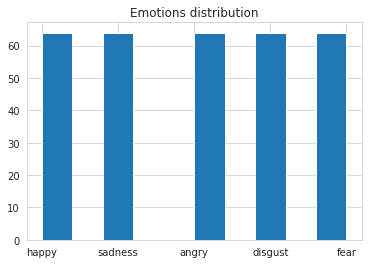

In [32]:
plt.title('Emotions distribution')
plt.hist(df_train['emotion_label'])
# plt.hist(y)
plt.show()

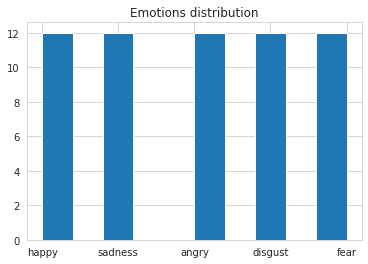

In [33]:
plt.title('Emotions distribution')
plt.hist(df_val['emotion_label'])
# plt.hist(y)
plt.show()

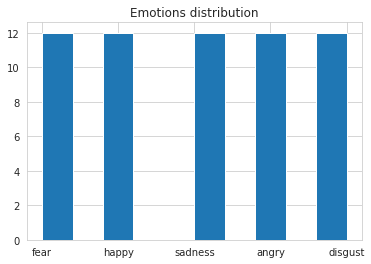

In [34]:
plt.title('Emotions distribution')
plt.hist(df_test['emotion_label'])
# plt.hist(y)
plt.show()

In [35]:
df_train.shape

(320, 4)

## Utils

In [36]:
def load_files(df):
    X = []
    for i in tqdm(df['path']): 
        X.append(librosa.load(i, res_type='kaiser_fast', sr=16000))
    return X

def extract_samples(X): 
    samples = []
    for ind,i in enumerate(X):
        samples.append(i[0])
    return samples 

def extract_labels(df): 
    labels = df['emotion_label'].copy()
    return labels 

def compute_lengths(samples): 
    lengths = [len(x) for x in samples]
    return lengths 

def check_outliers(lengths):
    # outliers
    lengths = np.array(lengths)
    print((lengths > 300000).sum())
    new_lengths = lengths[lengths < 300000]
    return new_lengths 

def compute_mean_length(lengths): 
    return lengths.mean()

def cut_and_pad(samples, labels, length_chosen = LENGTH_CHOSEN): 
    X_new = []
    y_new = []
    count = 0 
    for ind,i in enumerate(samples):
        if i.shape[0] < 300000:
            if i.shape[0] > length_chosen:
                new = i[:length_chosen]
                X_new.append(new)
            elif i.shape[0] < length_chosen:
                new = np.pad(i,math.ceil((length_chosen-i.shape[0])/2), mode='median')
                X_new.append(new)
            else:
                X_new.append(i)
            y_new.append(labels[count])
        count+=1
    
    return X_new, y_new

# Data Augmentation 
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# Data Augmentation 
def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)
    
def compute_mfccs(samples): 
    mfccs = []
    for i in tqdm(samples):
        mfcc = librosa.feature.mfcc(y=i, sr=16000, n_mfcc=13)
        mfcc = mfcc.T
        mfcc = np.array(mfcc)
        mfccs.append(mfcc[:, 1:])
    mfccs = np.array(mfccs)
    return mfccs

def compute_mfccs_augmentation(samples, labels): 
    mfccs = []
    counter = 0 
    for i in tqdm(samples):

       # Weiner Filtering on original noise 
        samples_weiner = scipy.signal.wiener(i)
        is_fin = np.isfinite(samples_weiner).all()


        # Data Augmentation - Noise 
        noise_audio = noise(samples_weiner)

        # Data Augmentation - Pitch 
        pitch_audio = pitch(samples_weiner, sampling_rate=16000)


        # Data Augmentation -  pitch + noise 
        pn = pitch(noise_audio, sampling_rate = 16000)


        if is_fin: 
          # MFCC

          mfcc = librosa.feature.mfcc(y=i, sr=16000, n_mfcc=13)
          mfcc = mfcc.T
          mfccs.append(mfcc[:, 1:])

          mfcc_augmented = librosa.feature.mfcc(y=samples_weiner, sr=16000, n_mfcc=13)
          mfcc_augmented = mfcc_augmented.T
          mfccs.append(mfcc_augmented[:, 1:])

          mfcc_augmented_pitch = librosa.feature.mfcc(y=noise_audio, sr=16000, n_mfcc=13)
          mfcc_augmented_pitch = mfcc_augmented_pitch.T
          mfccs.append(mfcc_augmented_pitch[:, 1:])

          mfcc_augmented_p = librosa.feature.mfcc(y=pitch_audio, sr=16000, n_mfcc=13)
          mfcc_augmented_p = mfcc_augmented_p.T
          mfccs.append(mfcc_augmented_p[:, 1:]) 

          mfcc_augmented_pn = librosa.feature.mfcc(y=pn, sr=16000, n_mfcc=13)
          mfcc_augmented_pn = mfcc_augmented_pn.T
          mfccs.append(mfcc_augmented_pn[:, 1:]) 
    
    mfccs = np.array(mfccs)
    
    # Copy labels 
    y_prov = []
    y = labels 
    for i in range(len(y)): 
      y_prov.append(y[i])
      y_prov.append(y[i])
      y_prov.append(y[i])
      y_prov.append(y[i])
      y_prov.append(y[i])
    y = np.asarray(y_prov)

    return mfccs, y 


## Train

### Load samples and labels 

In [37]:
load_train = load_files(df_train)

100%|███████████████████████████████████████| 320/320 [00:00<00:00, 2410.07it/s]


In [38]:
samples_train = extract_samples(load_train)

In [39]:
labels_train = extract_labels(df_train)

### Decide length

In [40]:
lengths = compute_lengths(samples_train) 

In [41]:
new_lengths = check_outliers(lengths) 

0


In [42]:
mean_length = compute_mean_length(new_lengths)

In [43]:
mean_length

38532.509375

### Cut and Pad

In [44]:
samples_train, labels_train = cut_and_pad(samples_train, labels_train)

In [45]:
samples_train = np.array(samples_train)
labels_train = np.array(labels_train)
print(samples_train.shape, labels_train.shape)

(320,) (320,)


### Feature Extraction - Without Data Augmentation 

In [46]:
mfccs_train = compute_mfccs(samples_train)

100%|█████████████████████████████████████████| 320/320 [00:03<00:00, 98.98it/s]


In [47]:
mfccs_train.shape

(320, 76, 12)

## Val

### Load samples and labels

In [48]:
load_val = load_files(df_val)

100%|█████████████████████████████████████████| 60/60 [00:00<00:00, 2197.27it/s]


In [49]:
samples_val = extract_samples(load_val)

In [50]:
labels_val = extract_labels(df_val)

### Cut and Pad 

In [51]:
samples_val, labels_val = cut_and_pad(samples_val, labels_val)

In [52]:
samples_val = np.array(samples_val)
labels_val = np.array(labels_val)
print(samples_val.shape, labels_val.shape)

(60,) (60,)


### Feature Extraction

In [53]:
mfccs_val = compute_mfccs(samples_val)

100%|██████████████████████████████████████████| 60/60 [00:00<00:00, 117.73it/s]


In [54]:
mfccs_val.shape

(60, 76, 12)

## Test

### Load samples and labels

In [55]:
load_test = load_files(df_test)

100%|█████████████████████████████████████████| 60/60 [00:00<00:00, 1428.04it/s]


In [56]:
samples_test = extract_samples(load_test)

In [57]:
labels_test = extract_labels(df_test)

### Cut and Pad 

In [58]:
samples_test, labels_test = cut_and_pad(samples_test, labels_test)

In [59]:
samples_test = np.array(samples_test)
labels_test = np.array(labels_test)
print(samples_test.shape, labels_test.shape)

(60,) (60,)


### Feature Extraction

In [60]:
mfccs_test = compute_mfccs(samples_test)

100%|██████████████████████████████████████████| 60/60 [00:00<00:00, 118.93it/s]


In [61]:
mfccs_test.shape

(60, 76, 12)

# Encode Labels - Binary 

In [62]:
emotion_enc = {'fear':1, 'disgust':1, 'neutral':0, 'calm':0,  'happy':0, 'sadness':1, 'surprise':0, 'angry':1}

In [63]:
y_train = pd.Series(labels_train).replace(emotion_enc)
#y_train_aug = pd.Series(labels_train_aug).map(emotion_enc)
y_val = pd.Series(labels_val).map(emotion_enc)
y_test = pd.Series(labels_test).map(emotion_enc)

# Train, Val, Test (X) 

In [64]:
X_train = mfccs_train
#X_train_aug = mfccs_train_aug 
X_val = mfccs_val
X_test = mfccs_test 

# Standard Scaling 

## Without Augmentation

In [65]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)

# Model 

In [66]:
model = Sequential()

model.add(layers.Conv1D(256, 7,padding='same',
                 input_shape=(248,12), kernel_initializer=tf.keras.initializers.HeNormal(seed=0)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling1D(pool_size=(4)))
model.add(layers.Dropout(0.6))

model.add(layers.Conv1D(128, 5,padding='same', kernel_initializer=tf.keras.initializers.HeNormal(seed=0)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling1D(pool_size=(4)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(64,  kernel_initializer=tf.keras.initializers.HeNormal(seed=0)))
model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))

model.summary()

2021-08-25 14:54:04.141551: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-25 14:54:04.141878: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 248, 256)          21760     
_________________________________________________________________
activation (Activation)      (None, 248, 256)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 62, 256)           0         
_________________________________________________________________
dropout (Dropout)            (None, 62, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 62, 128)           163968    
_________________________________________________________________
activation_1 (Activation)    (None, 62, 128)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 15, 128)           0

# Training

## Without Augmentation

### Load Data

In [67]:
weight_path = "/home/helemanc/Desktop/Binary_Model/weights/binary_model_l1l2.hdf5"

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.00001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=45, 
                                              verbose=1)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=weight_path, 
                                                      save_weights_only=True, 
                                                      monitor='val_accuracy', 
                                                      mode='max', 
                                                      save_best_only=True)
# classweight 
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}



In [68]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')

### Train

In [69]:
history = model.fit(X_train, y_train, batch_size=4, epochs=500, validation_data=(X_val, y_val),
           callbacks=[reduce_lr, early_stop, model_checkpoint], class_weight = class_weights)

2021-08-25 14:54:23.723125: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-08-25 14:54:23.741388: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2299965000 Hz


Epoch 1/500
80/80 [==============================] - 1s 9ms/step - loss: 6.5920 - accuracy: 0.6174 - val_loss: 0.9007 - val_accuracy: 0.7167
Epoch 2/500
80/80 [==============================] - 0s 6ms/step - loss: 1.7802 - accuracy: 0.6468 - val_loss: 0.6884 - val_accuracy: 0.5667
Epoch 3/500
80/80 [==============================] - 0s 6ms/step - loss: 1.5292 - accuracy: 0.6131 - val_loss: 0.4243 - val_accuracy: 0.7833
Epoch 4/500
80/80 [==============================] - 0s 5ms/step - loss: 1.1922 - accuracy: 0.6641 - val_loss: 0.4493 - val_accuracy: 0.8167
Epoch 5/500
80/80 [==============================] - 0s 5ms/step - loss: 0.6426 - accuracy: 0.7189 - val_loss: 0.4593 - val_accuracy: 0.8000
Epoch 6/500
80/80 [==============================] - 0s 5ms/step - loss: 0.7365 - accuracy: 0.7418 - val_loss: 0.4950 - val_accuracy: 0.7833
Epoch 7/500
80/80 [==============================] - 0s 6ms/step - loss: 0.5069 - accuracy: 0.7775 - val_loss: 0.4800 - val_accuracy: 0.8333
Epoch 8/500
8

### Plot Training Graphs

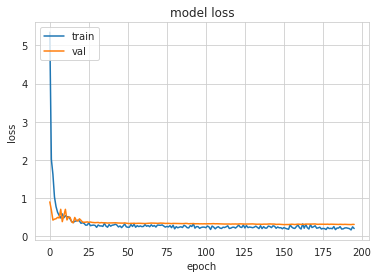

In [70]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

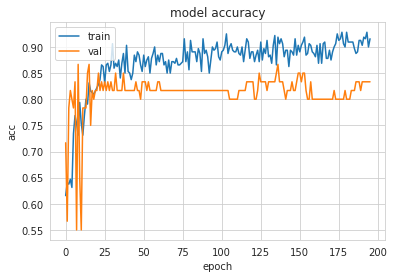

In [71]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Save Model

In [ ]:
model.save("/home/helemanc/Desktop/Binary_Model/models/binary_model")

### Evaluate Model

In [ ]:
model_loaded = tf.keras.models.load_model("/home/helemanc/Desktop/Binary_Model/models/binary_model")

In [72]:
model.evaluate(X_test, y_test, batch_size=4)

15/15 [==============================] - 0s 2ms/step - loss: 0.3533 - accuracy: 0.8333


[0.353274941444397, 0.8333333134651184]

In [73]:
from sklearn.metrics import classification_report
predictions = model.predict(X_test)
pred = [1 * (x[0]>=0.50) for x in predictions] #0.5 o 0.52? 
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.58      0.58      0.58        12
           1       0.90      0.90      0.90        48

    accuracy                           0.83        60
   macro avg       0.74      0.74      0.74        60
weighted avg       0.83      0.83      0.83        60



# Hyperparameters optimization

## Initializer, Batch Size, Learning Rate 

In [168]:
# create model input dim = 248 
'''
def create_model( init_mode='glorot_uniform', lr = 0.001):
    model = Sequential()

    model.add(layers.Conv1D(256, 5,padding='same',
                     input_shape=(248,12), kernel_initializer=init_mode))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(4)))
    model.add(layers.Dropout(0.6))

    model.add(layers.Conv1D(128, 5,padding='same', kernel_initializer=init_mode))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(4)))
    model.add(layers.Dropout(0.5))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, kernel_initializer=init_mode))
    model.add(layers.Dense(1))
    model.add(layers.Activation('sigmoid'))
    
    # compile model
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(lr = lr) , 
                  metrics=['accuracy'])
    return model
'''
def create_model( init_mode='glorot_uniform', lr = 0.001):
    model = Sequential()

    model.add(layers.Conv1D(256, 5,padding='same',
                     input_shape=(76,12), kernel_initializer=init_mode))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(4)))
    model.add(layers.Dropout(0.6))

    model.add(layers.Conv1D(128, 5,padding='same', kernel_initializer=init_mode))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(4)))
    model.add(layers.Dropout(0.5))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, kernel_initializer=init_mode))
    model.add(layers.Dense(1))
    model.add(layers.Activation('sigmoid'))
    
    # compile model
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(lr = lr) , 
                  metrics=['accuracy'])
    return model

In [169]:
weight_path = "/home/helemanc/Desktop/Binary_Model/weights/binary_model_l1l2.hdf5"

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.000001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=45, 
                                              verbose=1, restore_best_weights = True)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=weight_path, 
                                                      save_weights_only=True, 
                                                      monitor='val_accuracy', 
                                                      mode='max', 
                                                      save_best_only=True)
# classweight 
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}


In [170]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold, StratifiedKFold
#import tensorflow as tf 
#from tf.keras.wrappers.scikit_learn import KerasClassifier

seed = 7
np.random.seed(seed)
epochs = 50
batch_size = 4 
model_CV = tf.keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model, epochs=epochs, 
                           batch_size=batch_size, verbose=2)
# define the grid search parameters
init_mode = ['uniform', 'lecun_uniform', 'glorot_uniform', 'glorot_normal']
batches = [4,8,16]
lr = [0.001, 0.0001, 0.00005]

param_grid = dict(init_mode=init_mode, lr = lr, batch_size = batches)
grid = RandomizedSearchCV(estimator=model_CV, param_distributions=param_grid, n_jobs=-1, cv=StratifiedKFold(3))
grid_result = grid.fit(X_train, y_train, callbacks=[reduce_lr, early_stop], class_weight = class_weights)

2021-08-31 10:53:18.892845: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-31 10:53:18.893142: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-08-31 10:53:18.930639: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-31 10:53:18.930780: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-08-31 10:53:18.939842: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or dire

Epoch 1/50
14/14 - 1s - loss: 0.8774 - accuracy: 0.4601
Epoch 1/50
14/14 - 1s - loss: 0.8450 - accuracy: 0.5421
Epoch 1/50
54/54 - 1s - loss: 0.7500 - accuracy: 0.6103
Epoch 1/50
14/14 - 1s - loss: 0.9027 - accuracy: 0.4601
Epoch 1/50
14/14 - 2s - loss: 0.9723 - accuracy: 0.5305
Epoch 1/50
14/14 - 2s - loss: 0.6740 - accuracy: 0.6056
Epoch 1/50
54/54 - 2s - loss: 0.7227 - accuracy: 0.6682
Epoch 1/50
54/54 - 2s - loss: 0.7389 - accuracy: 0.5305
Epoch 2/50
14/14 - 1s - loss: 0.8231 - accuracy: 0.5258
Epoch 2/50
14/14 - 0s - loss: 0.7788 - accuracy: 0.5794
Epoch 2/50
14/14 - 1s - loss: 0.6477 - accuracy: 0.5540
Epoch 2/50
14/14 - 1s - loss: 0.8147 - accuracy: 0.5634
Epoch 2/50
54/54 - 1s - loss: 0.6866 - accuracy: 0.5446
Epoch 2/50
14/14 - 1s - loss: 0.7282 - accuracy: 0.6056
Epoch 3/50
14/14 - 1s - loss: 0.8620 - accuracy: 0.6056
Epoch 2/50
54/54 - 1s - loss: 0.6924 - accuracy: 0.4860
Epoch 3/50
14/14 - 1s - loss: 0.8360 - accuracy: 0.4673
Epoch 2/50
54/54 - 1s - loss: 0.7102 - accuracy:

In [171]:
# print results
print(f'Best Accuracy for {grid_result.best_score_} using {grid_result.best_params_}')
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f' mean={mean:.4}, std={stdev:.4} using {param}')

Best Accuracy for 0.8218714992205302 using {'lr': 0.001, 'init_mode': 'glorot_normal', 'batch_size': 4}
 mean=0.6628, std=0.05947 using {'lr': 5e-05, 'init_mode': 'glorot_uniform', 'batch_size': 16}
 mean=0.6657, std=0.01795 using {'lr': 5e-05, 'init_mode': 'uniform', 'batch_size': 4}
 mean=0.8187, std=0.01248 using {'lr': 0.001, 'init_mode': 'uniform', 'batch_size': 16}
 mean=0.7562, std=0.02058 using {'lr': 0.0001, 'init_mode': 'uniform', 'batch_size': 4}
 mean=0.7999, std=0.01656 using {'lr': 0.001, 'init_mode': 'glorot_uniform', 'batch_size': 8}
 mean=0.7094, std=0.01942 using {'lr': 0.0001, 'init_mode': 'uniform', 'batch_size': 8}
 mean=0.8219, std=0.0007897 using {'lr': 0.001, 'init_mode': 'glorot_normal', 'batch_size': 4}
 mean=0.8124, std=0.0269 using {'lr': 0.001, 'init_mode': 'lecun_uniform', 'batch_size': 8}
 mean=0.7656, std=0.02292 using {'lr': 0.0001, 'init_mode': 'glorot_normal', 'batch_size': 8}
 mean=0.7375, std=0.01985 using {'lr': 5e-05, 'init_mode': 'lecun_uniform',

## Train with best parameters

In [66]:
# Best Accuracy for 0.875 using {'lr': 0.001, 'init_mode': 'lecun_uniform', 'batch_size': 8}
# New length best parameters: 
# Best Accuracy for 0.8218714992205302 using {'lr': 0.001, 'init_mode': 'glorot_uniform', 'batch_size': 8}
'''
def create_model( init_mode='glorot_uniform', lr = 0.001):
    model = Sequential()

    model.add(layers.Conv1D(256, 5,padding='same',
                     input_shape=(248,12), kernel_initializer=init_mode))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(4)))
    model.add(layers.Dropout(0.6))

    model.add(layers.Conv1D(128, 5,padding='same', kernel_initializer=init_mode))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(4)))
    model.add(layers.Dropout(0.5))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, kernel_initializer=init_mode))
    model.add(layers.Dense(1))
    model.add(layers.Activation('sigmoid'))
    
    # compile model
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(lr = lr) , 
                  metrics=['accuracy'])
    return model
'''
def create_model( init_mode='glorot_uniform', lr = 0.001):
    model = Sequential()

    model.add(layers.Conv1D(256, 5,padding='same',
                     input_shape=(76,12), kernel_initializer=init_mode))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(4)))
    model.add(layers.Dropout(0.6))

    model.add(layers.Conv1D(128, 5,padding='same', kernel_initializer=init_mode))
    model.add(layers.Activation('relu'))
    model.add(layers.MaxPooling1D(pool_size=(4)))
    model.add(layers.Dropout(0.5))

    model.add(layers.Flatten())
    model.add(layers.Dense(64, kernel_initializer=init_mode))
    model.add(layers.Dense(1))
    model.add(layers.Activation('sigmoid'))
    
    # compile model
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(lr = lr) , 
                  metrics=['accuracy'])
    return model

In [67]:
seed = 7
np.random.seed(seed)

In [68]:
model = create_model()

2021-08-31 11:21:29.472201: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-31 11:21:29.472597: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


In [69]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [70]:
import datetime, os

In [72]:
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [73]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

2021-08-31 11:21:36.489666: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-08-31 11:21:36.489768: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-08-31 11:21:36.547396: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


In [74]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', 
                                                 factor=0.5, patience=4, 
                                                 verbose=1, mode='max', 
                                                 min_lr=0.000001)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=45, 
                                              verbose=1, restore_best_weights = True )

# classweight 
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weights = {l:c for l,c in zip(np.unique(y_train), class_weights)}

In [75]:
history = model.fit(X_train, y_train, batch_size=8, epochs=500, validation_data=(X_val, y_val),
           callbacks=[reduce_lr, early_stop, tensorboard_callback], class_weight = class_weights)

2021-08-31 11:21:37.228956: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-08-31 11:21:37.247682: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2299965000 Hz


Epoch 1/500
26/40 [==================>...........] - ETA: 0s - loss: 0.9638 - accuracy: 0.5729

2021-08-31 11:21:37.744010: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-08-31 11:21:37.744036: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-08-31 11:21:37.748855: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2021-08-31 11:21:37.750168: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-08-31 11:21:37.751965: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20210831-112136/train/plugins/profile/2021_08_31_11_21_37
2021-08-31 11:21:37.752763: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/20210831-112136/train/plugins/profile/2021_08_31_11_21_37/helemanc-Latitude-5410.trace.json.gz
2021-08-31 11:21:37.754995: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/20210831-112136/train/plugins/p

40/40 [==============================] - 1s 12ms/step - loss: 0.9776 - accuracy: 0.5747 - val_loss: 0.6661 - val_accuracy: 0.6167
Epoch 2/500
40/40 [==============================] - 0s 4ms/step - loss: 0.6230 - accuracy: 0.7362 - val_loss: 0.5984 - val_accuracy: 0.7000
Epoch 3/500
40/40 [==============================] - 0s 4ms/step - loss: 0.6714 - accuracy: 0.7076 - val_loss: 0.3883 - val_accuracy: 0.8167
Epoch 4/500
40/40 [==============================] - 0s 5ms/step - loss: 0.6333 - accuracy: 0.7166 - val_loss: 0.4947 - val_accuracy: 0.7667
Epoch 5/500
40/40 [==============================] - 0s 4ms/step - loss: 0.4475 - accuracy: 0.7923 - val_loss: 0.4385 - val_accuracy: 0.8000
Epoch 6/500
40/40 [==============================] - 0s 4ms/step - loss: 0.4449 - accuracy: 0.7843 - val_loss: 0.3704 - val_accuracy: 0.8333
Epoch 7/500
40/40 [==============================] - 0s 4ms/step - loss: 0.4803 - accuracy: 0.7802 - val_loss: 0.4903 - val_accuracy: 0.7833
Epoch 8/500
40/40 [=====

In [76]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 31441), started 23:59:11 ago. (Use '!kill 31441' to kill it.)

In [77]:
model.evaluate(X_test, y_test, batch_size=4)

15/15 [==============================] - 0s 1ms/step - loss: 0.3048 - accuracy: 0.8833


[0.3047849237918854, 0.8833333253860474]

In [78]:
from sklearn.metrics import classification_report
predictions = model.predict(X_test)
pred = [1 * (x[0]>=0.50) for x in predictions] #0.5 o 0.52? 
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.78      0.58      0.67        12
           1       0.90      0.96      0.93        48

    accuracy                           0.88        60
   macro avg       0.84      0.77      0.80        60
weighted avg       0.88      0.88      0.88        60

